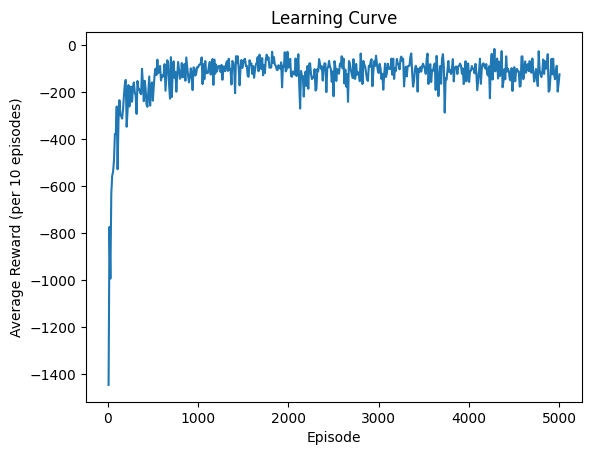

Episode length: 13, Total Return: -11.548880536994798, Episode : [(36, 0, -1), (24, 1, -1), (25, 1, -1), (26, 1, -1), (27, 1, -1), (28, 1, -1), (29, 1, -1), (30, 1, -1), (31, 1, -1), (32, 1, -1), (33, 1, -1), (34, 1, -1), (35, 2, -1)]


([(36, 0, -1),
  (24, 1, -1),
  (25, 1, -1),
  (26, 1, -1),
  (27, 1, -1),
  (28, 1, -1),
  (29, 1, -1),
  (30, 1, -1),
  (31, 1, -1),
  (32, 1, -1),
  (33, 1, -1),
  (34, 1, -1),
  (35, 2, -1)],
 True)

In [6]:


from typing import Any
import random
import gymnasium as gym
import matplotlib.pyplot as plt

def argmax_action(d: dict[Any,float]) -> Any:
    """return a key of the maximum value in a given dictionary

    Args:
        d (dict[Any,float]): dictionary

    Returns:
        Any: a key
    """
    if not d:
        return None

    # Including random choice in case of tie-break
    max_val = max(d.values())
    best = [k for k, v in d.items() if v == max_val]
    return random.choice(best)

class ValueRLAgent():
    def __init__(self, env: gym.Env, gamma : float = 0.98, eps: float = 0.2, alpha: float = 0.02, total_epi: int = 5_000) -> None:
        """initialize agent parameters
        This class will be a parent class and not be called directly.

        Args:
            env (gym.Env): gym environment
            gamma (float, optional): a discount factor. Defaults to 0.98.
            eps (float, optional): the epsilon value. Defaults to 0.2. Note: this pa uses a simple eps-greedy not decaying eps-greedy.
            alpha (float, optional): a learning rate. Defaults to 0.02.
            total_epi (int, optional): total number of episodes an agent should learn. Defaults to 5_000.
        """
        self.env = env
        self.q = self.init_qtable(env.observation_space.n, env.action_space.n)
        self.gamma = gamma
        self.eps = eps
        self.alpha = alpha
        self.total_epi = total_epi

    def init_qtable(self, n_states: int, n_actions: int, init_val: float = 0.0) -> dict[int,dict[int,float]]:
        """initialize the q table (dictionary indexed by s, a) with a given init_value

        Args:
            n_states (int, optional): the number of states. Defaults to int.
            n_actions (int, optional): the number of actions. Defaults to int.
            init_val (float, optional): all q(s,a) should be set to this value. Defaults to 0.0.

        Returns:
            dict[int,dict[int,float]]: q table (q[s][a] -> q-value)
        """

        # Initialising q-table for each state-action pair
        q = dict()
        for s in range(n_states):
            q[s] = dict()
            for a in range(n_actions):
                q[s][a] = init_val

        return q

    def eps_greedy(self, state: int, exploration: bool = True) -> int:
        """epsilon greedy algorithm to return an action

        Args:
            state (int): state
            exploration (bool, optional): explore based on the epsilon value if True; take the greedy action by the current self.q if False. Defaults to True.

        Returns:
            int: action
        """
        # Epsilon greedy algorithm:
        # P(greedy_action) = (1 - epsilon) + (epsilon / k)
        # P(non_greedy_action) = epsilon / k

        greedy_action = argmax_action(self.q[state])
        if exploration:
            per_action_eps = self.eps / self.env.action_space.n
            prob_for_each_action = [per_action_eps] * self.env.action_space.n # for actions including greedy action
            prob_for_each_action[greedy_action] = 1 - self.eps + per_action_eps # only for greedy action
            random_action = random.choices(range(self.env.action_space.n), weights=prob_for_each_action)[0]
            return random_action
        else:
            return greedy_action

    def choose_action(self, ss: int) -> int:
        """a helper function to specify a exploration policy
        If you want to use the eps_greedy, call the eps_greedy function in this function and return the action.

        Args:
            ss (int): state

        Returns:
            int: action
        """

        return self.eps_greedy(ss)

    def best_run(self, max_steps: int = 100) -> tuple[list[tuple[int,int,float]], bool]:
        """After the learning, an optimal episode (based on the latest self.q) needs to be generated for evaluation. From the initial state, always take the greedily best action until it reaches a goal.

        Args:
            max_steps (int, optional): Terminate the episode generation if the agent cannot reach the goal after max_steps. One step is (s,a,r) Defaults to 100.

        Returns:
            tuple[
                list[tuple[int,int,float]],: An episode [(s1,a1,r1), (s2,a2,r2), ...]
                bool: done - True if the episode reaches a goal, False if it hits max_steps.
            ]
        """
        episode = list()
        done = False
        current_state = self.env.reset()[0]
        for _ in range(max_steps):
            action = argmax_action(self.q[current_state]) # because we only take best actions for the best run
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            episode.append((current_state, action, reward))
            if terminated or truncated:
                done = True
                break
            current_state = next_state

        # Adding length and total return to the output
        print(f"Episode length: {len(episode)}, Total Return: {self.calc_return(episode, done)}, Episode : {episode}")
        return (episode, done)

    def calc_return(self, episode: list[tuple[int,int,float]], done=False) -> float:
        """Given an episode, calculate the return value. An episode is in this format: [(s1,a1,r1), (s2,a2,r2), ...].

        Args:
            episode (list[tuple[int,int,float]]): An episode [(s1,a1,r1), (s2,a2,r2), ...]
            done (bool, optional): True if the episode reaches a goal, False if it does not. Defaults to False.

        Returns:
            float: the return value. None if done is False.
        """

        if not done:
            return None

        return_value = 0
        num = 0
        for obs in episode:
            return_value += obs[2] * self.gamma ** num
            num += 1

        return return_value

class DoubleQLAgent(ValueRLAgent):
    def __init__(self, env, gamma = 0.98, eps = 0.2, alpha = 0.02, total_epi = 5000):
        super().__init__(env, gamma, eps, alpha, total_epi)

    def learn(self):
        """Double Q-Learning algorithm
        Update the Q table (self.q) for self.total_epi number of episodes.

        The results should be reflected to its q table.
        """

        # Intialising both q1 and q2 tables
        q1_table = self.init_qtable(self.env.observation_space.n, self.env.action_space.n)
        q2_table = self.init_qtable(self.env.observation_space.n, self.env.action_space.n)

        number_of_epis = 0
        episodic_return = []
        total_return = 0.0

        # Loop for all episodes
        for _ in range(self.total_epi):
            current_state = self.env.reset()[0]
            done = False
            number_of_epis += 1

            # Loop for each episode
            while not done:
                action = self.choose_action(current_state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                if random.random() < 0.5:
                    if done:
                        target = reward # for the case when next state is terminal
                    else:
                        target = reward + self.gamma * q2_table[next_state][argmax_action(q1_table[next_state])]
                    q1_table[current_state][action] += self.alpha * (target - q1_table[current_state][action])
                else:
                    if done:
                        target = reward # for the case when next state is terminal
                    else:
                        target = reward + self.gamma * q1_table[next_state][argmax_action(q2_table[next_state])]
                    q2_table[current_state][action] += self.alpha * (target - q2_table[current_state][action])

                # Update the self.q table for current state-action pair
                self.q[current_state][action] = (q1_table[current_state][action] + q2_table[current_state][action]) / 2
                current_state = next_state
                total_return += reward
                if terminated or truncated:
                    done = True
                    break # break the loop if episode ends
            episodic_return.append(total_return)
            total_return = 0

        # Update the self.q table for all the state action pairs to avoid stale data
        for s in range(self.env.observation_space.n):
            for a in range(self.env.action_space.n):
                self.q[s][a] = 0.5 * (q1_table[s][a] + q2_table[s][a])

        # Calculate the rolling average return for all episodes
        avg_rewards = []
        for i in range(0, len(episodic_return), 10):
            chunk = episodic_return[i:i+10]
            avg_rewards.append(sum(chunk) / len(chunk))

        # Plot the learning curve that shows the average reward every 10 episodes
        episode_numbers = list(range(10, len(episodic_return) + 1, 10))
        plt.plot(episode_numbers, avg_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Average Reward (per 10 episodes)")
        plt.title("Learning Curve")
        plt.show()

# Run the agent in the cliff walking (or any other) gym environment
my_agent = DoubleQLAgent(env=gym.make("CliffWalking-v1"))
my_agent.learn()
my_agent.env = gym.make("CliffWalking-v1", render_mode="human")
my_agent.best_run()


